## Introduction
This notebook demonstrates how to scale the CIFAR-10 image classification task using multiple FPGAs.
In the first step, we connect to an existing Dask cluster using it's scheduler's IP address.

In [51]:
from dask.distributed import Client, progress, get_worker
import os
import binascii

# Replace with IP address of the Dask scheduler
client = Client("tcp://131.180.106.138:8786") 
client

Client Scheduler: tcp://131.180.106.138:8786 Dashboard: http://131.180.106.138:8787/status,Cluster Workers: 1 Cores: 1 Memory: 0 B


### Define experiment parameters:

BATCH_SIZES => A list of different batch sizes (number of images) we would like to run this experiment for.

PLATFORM => One of the two supported platforms by the driver (alveo/zynq-iodma)

XCLBIN_PATH_DEFAULT => Default path for the .xclbin file if one not provided via command line args

DEVICE_NAME_DEFAULT => Default name for the FPGA device if one not provided via command line args

In [31]:
BATCH_SIZES = [100, 500]
BATCH_SIZES = [100, 500, 1000, 1500, 2000]
PLATFORM = "alveo"
XCLBIN_PATH_DEFAULT = "a.xclbin"
DEVICE_NAME_DEFAULT = "xilinx_u50_gen3x16_xdma_201920_3"

### Download dataset
Download a numpy-array formatted CIFAR-10 dataset to the current directory:

In [50]:
!wget https://raw.githubusercontent.com/modestyachts/CIFAR-10.1/master/datasets/cifar10.1_v4_data.npy

--2020-11-29 13:14:58--  https://raw.githubusercontent.com/modestyachts/CIFAR-10.1/master/datasets/cifar10.1_v4_data.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6208640 (5.9M) [application/octet-stream]
Saving to: ‘cifar10.1_v4_data.npy.10’

100%[======================================>] 6,208,640   --.-K/s   in 0.08s   

2020-11-29 13:14:58 (73.6 MB/s) - ‘cifar10.1_v4_data.npy.10’ saved [6208640/6208640]



### Define the worker method

Here, we define the Python method which will be executed on each of the Dask workers. This function calls the driver using the data partition it receives, and returns the output data (along with some performance statistics) to the caller (the Dask client)

The little dance with the forking logic is needed since Pynq (used internally by *FINNAccelDriver*) cannot run in a non-main thread, which is how a Dask worker runs. 



In [52]:
def run_on_worker(ibuf_normal, index):
    print("Received ", len(ibuf_normal), "images for classification")
    from multiprocessing import Process,Queue
    import numpy as np
    import time
    
    def forked_process(queue, ibuf_normal):
        from driver import FINNAccelDriver
        from pynq.ps import Clocks
        
        batch_size = len(ibuf_normal) 
        
        device_name = os.environ.get('DEVICE_NAME', DEVICE_NAME_DEFAULT)
        xclbin_path = os.environ.get('XCLBIN_PATH', XCLBIN_PATH_DEFAULT)
        print("Using parameters: DEVICE_NAME =", device_name, " XCLBIN_PATH =", xclbin_path, " PLATFORM =", PLATFORM)
        
        finnDriver = FINNAccelDriver(batch_size, xclbin_path, PLATFORM, device_name)
        ibuf_folded = finnDriver.fold_input(ibuf_normal)
#         ibuf_packed = finnDriver.pack_input(ibuf_folded)   Do not pack for performance reasons
        ibuf_packed = ibuf_folded
        finnDriver.copy_input_data_to_device(ibuf_packed)
        t0 = time.time()
        finnDriver.execute()
        t1 = time.time()
        obuf_packed = np.empty_like(finnDriver.obuf_packed_device)
        finnDriver.copy_output_data_from_device(obuf_packed)
        obuf_folded = finnDriver.unpack_output(obuf_packed)
        obuf_normal = finnDriver.unfold_output(obuf_folded)
        
        if PLATFORM != "alveo":
            fclk_mhz = Clocks.fclk0_mhz
        else:
            fclk_mhz = finnDriver.fclk_mhz
        runtime = t1-t0
        queue.put({
            'data': obuf_normal,
            'runtime': runtime,
            'index': index,
            'fclk_mhz': fclk_mhz,
            'throughput': batch_size/runtime,
            'bandwidth_in': np.prod(finnDriver.ishape_packed)*0.000001 / runtime,
            'bandwidth_out': np.prod(finnDriver.oshape_packed)*0.000001 / runtime,
            'N': batch_size
            
        })
    
    
    # We need to run the Pynq overlay in a new forked process since it cannot be run in a non-Main thread
    t0_total = time.time()
    queue = Queue()
    p = Process(target=forked_process, args=(queue, ibuf_normal))
    p.start()
    result = queue.get()
    p.join()
    t1_total = time.time()
    print("TOTAL EXECUTION TIME ON THIS WORKER (s): ", t1_total - t0_total)
    return result

### Run the experiment
Now we can run the classification.

1. Partition the dataset into as many parts as the number of workers
2. Send each part to a separate worker (using the *scatter* function from Dask)
3. Submit the *run_on_worker* defined above to the scheduler, which will run it on all the workers.
4. Collect and merge the results

In [53]:
import time
import numpy as np
import json

num_of_workers = len(client.scheduler_info()["workers"])
full_cifar = np.load('cifar10.1_v4_data.npy')

execution_times = []
end_to_end_times = []
for BATCH_SIZE in BATCH_SIZES:
    print("BATCH_SIZE:", BATCH_SIZE)
    partial_cifar = full_cifar[:BATCH_SIZE]
    t0 = time.time()
    
    # Split up the file into equal sized chunks based on number of available Dask workers
    data_split = []
    start = 0
    chunk_size = int(len(partial_cifar)/num_of_workers)
    for i in range(num_of_workers - 1):
        data_split.append(partial_cifar[start: start+chunk_size])
        start += chunk_size
    data_split.append(partial_cifar[start:]) #Last partition

    # Scatter the data to the workers before calling run_on_worker on the workers
    print("Sending data to workers, and triggering worker tasks...")
    
    distributed_data = client.scatter(data_split)
    futures = client.map(run_on_worker, distributed_data, range(num_of_workers))
    results = client.gather(futures)
    print("Received data from workers.")

    # Reorder the response based on original input order
    results.sort(key = lambda result: result['index'])  

    # Concatenate the result where each is an ndarray of the shape (BATCH_SIZE/num_of_workers, 1)
    merged_result = np.concatenate([r['data'] for r in results]) # FINAL RESULTS (CLASS LABELS)
    
    t1 = time.time()
    max_fpga_runtime = max([r['runtime'] for r in results])
    def avg(li):
        return sum(li)/len(li)

    print("TOTAL EXECUTION TIME:", t1-t0)
    print("Maximum FPGA runtime[s]:", max_fpga_runtime) # Shown in the plot
    print("Average throughput[images/s]:", avg([r['throughput'] for r in results]))
    print("Average DRAM_in_bandwidth[Mb/s]:", avg([r['bandwidth_in'] for r in results])) 
    print("Average DRAM_out_bandwidth[Mb/s]:", avg([r['bandwidth_out'] for r in results]))    
    print("**************************")   
    execution_times.append(max_fpga_runtime)
    end_to_end_times.append(t1-t0)

BATCH_SIZE: 100
Sending data to workers, and triggering worker tasks...
Received data from workers.
TOTAL EXECUTION TIME: 1.7943508625030518
Maximum FPGA runtime[s]: 0.03719615936279297
Average throughput[images/s]: 2688.4496064405303
Average DRAM_in_bandwidth[Mb/s]: 8.258917190985308
Average DRAM_out_bandwidth[Mb/s]: 0.00268844960644053
**************************
BATCH_SIZE: 500
Sending data to workers, and triggering worker tasks...
Received data from workers.
TOTAL EXECUTION TIME: 1.4187006950378418
Maximum FPGA runtime[s]: 0.16806292533874512
Average throughput[images/s]: 2975.076144796406
Average DRAM_in_bandwidth[Mb/s]: 9.139433916814559
Average DRAM_out_bandwidth[Mb/s]: 0.002975076144796406
**************************
BATCH_SIZE: 1000
Sending data to workers, and triggering worker tasks...
Received data from workers.
TOTAL EXECUTION TIME: 1.5443880558013916
Maximum FPGA runtime[s]: 0.332075834274292
Average throughput[images/s]: 3011.360348413694
Average DRAM_in_bandwidth[Mb/s]: 

### Generate a performance plot
Plot the execution times for different batch sizes. Here, we plot the maximum FPGA execution times from all the workers. This time includes the data buffering time to/from the FPGA and the actual inference time. To plot the total end-to-end time instead, replace the *execution_times* variable below with the *end_to_end_times* variable.

<Figure size 3600x3600 with 0 Axes>

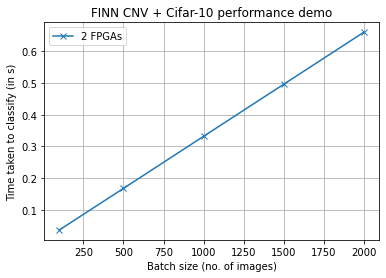

In [54]:
import numpy as np
import matplotlib.pyplot as plt
f = plt.figure(figsize=(50,50))
x = BATCH_SIZES
f = plt.figure()

y2 = execution_times
plt.plot(x, y2, label = "2 FPGAs", marker='x')

plt.xlabel('Batch size (no. of images)')
plt.ylabel('Time taken to classify (in s)')
plt.title('FINN CNV + Cifar-10 performance demo')

plt.legend()
plt.grid()

f.savefig("cnv-1-vs-2.png", bbox_inches='tight', dpi=150)

### Measure scaling benefits
To measure the benefits of scaling, run this notebook again after creating or destroying one or more Dask workers. Then compare the plots above to see the speedup.